# Introduction to FLoX 2.0

## Piece #1: Flock Networks
We refer to the topology that makes up our devices as a ``Flock`` (think a *flock* of birds). Each ``Flock`` is organized as a tree, with a root, middle nodes, and leaves.

A ``Flock`` is made up of the following types of nodes:
1. a single ``leader`` node which orchestrates the FL process
2. some **optional** number of ``aggregator`` nodes in the middle
3. ``worker`` nodes which are leaves of the tree and do local model training

### Defining a Flock
There are a few ways to define your ``Flock`` network. The **recommended approach** is to simply import it from a file (preferably a `*.yaml` file).

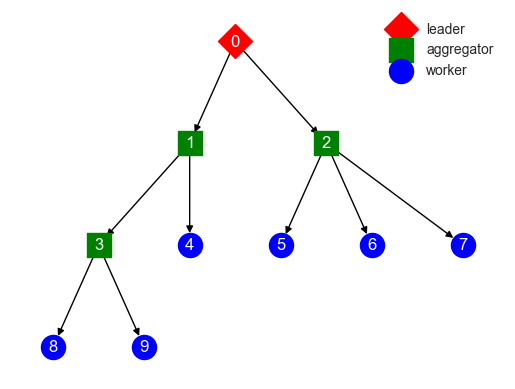

In [1]:
import sys, os
from pathlib import Path

cwd = os.getcwd()
cwd = Path(cwd)
if cwd not in sys.path:
    sys.path.append(str(cwd.parent.parent))

import matplotlib.pyplot as plt
from flox.flock import Flock

flock = Flock.from_yaml("../flocks/complex.yaml")
flock.draw()
plt.legend(frameon=False)
plt.show()

## Piece #2: Federated Dataset
For FL, of course data are one of the centerpieces. First, let's start with some benchmark dataset from the deep learning world: `FashionMNIST`!

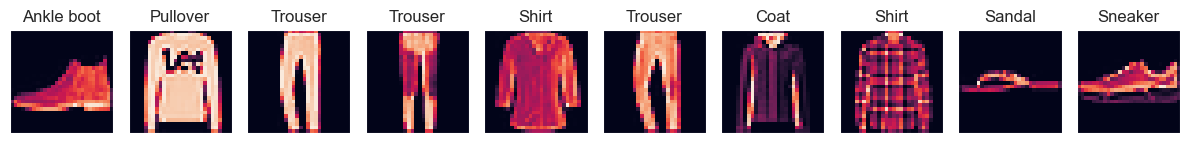

In [2]:
import os
from torchvision.datasets import FashionMNIST

fashion_mnist = FashionMNIST(root=os.environ["TORCH_DATASETS"], download=False, train=False)
label_map = {
    0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
    5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot",
}

num = 10
fig, axes = plt.subplots(nrows=1, ncols=num, figsize=(12, 6))
for i, (image, label) in enumerate(fashion_mnist):
    axes[i].imshow(image)
    axes[i].set_title(label_map[label])
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    if i >= num - 1:
        break

plt.tight_layout()
plt.show()

### federated_split()
However, these data are all "centralized". For FL, we need *decentralized* data.

We implemented a handy little utility function, `federated_split()`, to make this convenient for us.

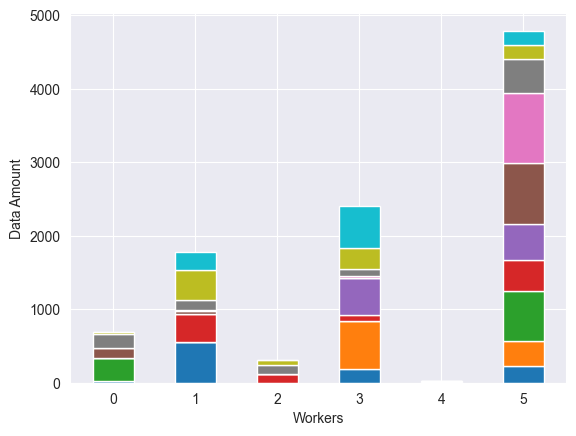

In [3]:
import os
from flox.data import federated_split, fed_barplot
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

data = FashionMNIST(root=os.environ["TORCH_DATASETS"], download=False, train=False, transform=ToTensor())
federated_data = federated_split(
    data,
    flock,
    10,
    samples_alpha=1.0,
    labels_alpha=0.1
)
fed_barplot(federated_data, 10)
plt.xlabel("Workers")
plt.ylabel("Data Amount")
plt.show()

# Piece #3: Deep Neural Network Model
``FLoX`` 2.0 is built around using ``PyTorch`` as its deep learning framework of choice. 

However, ``PyTorch`` has a lot of boilerplate because of its flexibility. The popular ``PyTorch Lightning`` framework is meant to reduce the boilerplate needed to train PyTorch models. But, it is designed for large-scale deep learning in mind (i.e., think high-performance computing).

With this in mind, we have a ``FloxModule`` wrapper around the PyTorch ``Module`` based off of the ``LightningModule`` from ``PyTorch Lightning``.  

In [4]:
import torch.nn as nn
from flox.nn import FloxModule
from torch.optim import SGD


class MyModule(FloxModule):
    def __init__(self, lr: float = 0.01):
        super().__init__()
        self.lr = lr
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear_stack(x)

    def training_step(self, batch, batch_idx):
        # This callback is added by ``FloxModule`` and based on the ``LightningModule``
        inputs, targets = batch
        preds = self(inputs)
        loss = nn.functional.cross_entropy(preds, targets)
        return loss

    def configure_optimizers(self):
        # This callback is added by ``FloxModule`` and based on the ``LightningModule``
        return SGD(self.parameters(), lr=self.lr)

# Bringing it All Together: Launching an FL Process!
Now that we have the 3 required components from us, we have everything we need to run an FL process.

Next, all we need to do is just dump it into the `federated_fit()` function.

In [5]:
from flox.run import federated_fit
from flox.strategies.registry.fedavg import FedAvg
from pandas import DataFrame

module, results = federated_fit(
    flock,
    MyModule,
    federated_data,
    num_global_rounds=5,
    strategy="fedavg",
    # where="local"
)
results.head()

federated_fit::sync: 100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


,train/loss,train/epoch,train/batch_idx,train/time,node/idx,node/kind,parent/idx,parent/kind,round
0,2.313314,0,0,2023-12-04 16:34:46.308850,8,worker,3,aggregator,0
0,2.304092,0,0,2023-12-04 16:34:46.319090,9,worker,3,aggregator,0
1,2.298470,0,1,2023-12-04 16:34:46.321681,9,worker,3,aggregator,0
2,2.299997,0,2,2023-12-04 16:34:46.324216,9,worker,3,aggregator,0
3,2.297341,0,3,2023-12-04 16:34:46.326899,9,worker,3,aggregator,0


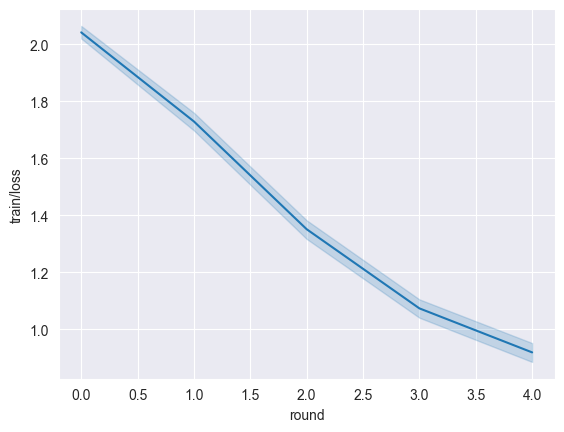

In [6]:
import seaborn as sns

sns.set_style("darkgrid")
sns.lineplot(results, x="round", y="train/loss")
plt.show()